In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.insert(0, '../')
#sys.path.insert(1, '/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages')
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.overlap import get_overlap, get_mismatch
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *

### Creating your own modules!

In addition to using our built-in modules and waveforms, you can easily create your own module or waveform. Below is an example of creating your own trajectory module and using it in a custom waveform. If you can get a reasonably fast trajectory from your specific brand of EMRI physics, you can be generating waveforms in no time! Please see the [documentation]() on this for more details on the constructions behind this. 

**Important Note**: If you do use this package to examine EMRI analysis problems, please contact the authors of this code (see docs) about possible collaboration and/or contribution.

### Post-Newtonian trajectory

The example will be to implement a Post-Newtonian trajectory in a Schwarzschild eccentric waveform. This will be done purely in Python. However, most of our modules have backends in C/C++/CUDA for maximum efficiency. If you have a trajectory in python and want to see if it can be ported for speed, please contact the authors.

To get started, we will import an integrator ([DOP853](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.DOP853.html#scipy.integrate.DOP853)) and a library for elliptical integrals that mirrors the mathematica format `mpmath`. You can run: 

```
pip install mpmath
```

in your conda environment to attain that library. 

We will also import necessary things from our package. This includes constants from `few.utils.constants`, as well as two base classes to be inherited by the new module. 

The first base class is [SchwarzschildEccentric](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.utils.baseclasses.SchwarzschildEccentric) base class that passes information specific to any Schwarzschild eccentric waveform (number of modes, (l,m,n) pairs, etc.). It also has methods for general sanity checks in these limits for input parameters, trajectories, and other things. You can see the documentation for more detail on its properties. 

The other base class is [TrajectoryBase](file:///Users/michaelkatz/Research/FastEMRIWaveforms/docs/html/user/traj.html#few.utils.baseclasses.TrajectoryBase). This houses both information for trajectory modules, as well as the interface that should be common to all trajectory modules (i.e. [__call__](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/traj.html?highlight=trajectorybase#few.utils.baseclasses.TrajectoryBase.__call__) function). It allows for flexible parameter calling interfaces, but ensures the strict interface will be the same for all trajectory modules. Trajectory modules must implement the method [get_inspial](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/traj.html?highlight=trajectorybase#few.utils.baseclasses.TrajectoryBase.get_inspiral). The common interface uses this to generate the specific trajectory. 

This is a common theme amongst module and waveform creation. The user will take one parent abstract base class related to the waveform limits, domain of validity, and its waveform properties, and one parent abstract based class for the module type (like trajectory or summation). 

In [2]:
# we need to import an integrator and elliptic integrals
from mpmath import *
from scipy.integrate import DOP853

# base classes
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

# settings for elliptic integrals
mp.dps = 25
mp.pretty = True

# constants from our package
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class PN:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon

        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y
        
        # guard against bad integration steps
        if e >= 1.0 or e < 1e-2 or p < 6.0 or (p - 6 - 2* e) < 0.1:
            return [0.0, 0.0]
        

        # perform elliptic calculations
        EllipE 	= ellipe(4*e/(p-6.0+2*e))
        EllipK 	= ellipk(4*e/(p-6.0+2*e))
        EllipPi1 = ellippi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        EllipPi2 = ellippi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (EllipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = pow(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux
        Edot = -epsilon*(EdotPN)
        Ldot = -epsilon*(LdotPN)

        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))
        
        Phi_phi_dot = Omega_phi;

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*Pi)/(8*EllipK + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]

        return dydt

    
# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class PnTrajectory(TrajectoryBase):
    
    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass
    
    # required by the trajectory base class
    def get_inspiral(self, M, mu, p0, e0, T=1.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        epsilon = mu/M
        integrator = DOP853(PN(epsilon), 0.0, y0, T)

        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        
        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:
            integrator.step()
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            if (p - 6 -2*e) < 0.1:
                run = False

        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)
        flux = np.zeros_like(t)

        return (t, p, e, Phi_phi, Phi_r, flux)

### Test your trajectory!

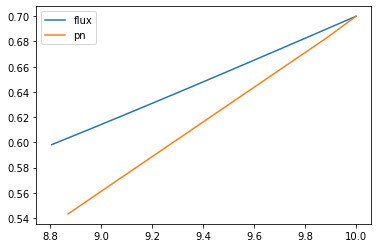

In [3]:
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7
T = 1.0

traj = PnTrajectory()

test = traj(M, mu, p0, e0, T=T, dt=10.0)

traj2 = RunSchwarzEccFluxInspiral()

flux = traj2(M, mu, p0, e0, T=T, dt=10.0)

p = test[1]
e = test[2] 

import matplotlib.pyplot as plt
plt.plot(flux[1], flux[2], label='flux')
plt.plot(p, e, label='pn')


plt.legend()
plt.savefig('trajectory_pn_vs_flux.pdf', dpi=200)

### Make a waveform model

Now we will create a waveform with our new trajectory model. To do this, we will start with [SchwarzschildEccentricWaveformBase](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.waveform.SchwarzschildEccentricWaveformBase). This base class has already inherited from [SchwarzschildEccentric](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.utils.baseclasses.SchwarzschildEccentric). It creates the common interface for all waveform modules (and how they interface with there constituent modules). A requirement when creating a module is to have properties describing the GPU capability of the waveform, as well as whether or not it allows for batching the waveform creation (after trajectory).  

In [4]:
class FastSchwarzschildEccentricPn(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            PnTrajectory,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

### Test it!

It will have the same interface as the other waveforms. 

mismatch: 1.001340224043205


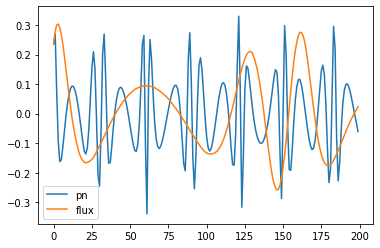

In [6]:
test = FastSchwarzschildEccentricPn(normalize_amps=False)

few = FastSchwarzschildEccentricFlux()

M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3.
phi = np.pi/4.

T = 0.2
dt = 15.0

wave1 = test(M, mu, p0, e0, theta, phi, dt=dt, T=T)

wave2 = few(M, mu, p0, e0, theta, phi, dt=dt, T=T)

plt.plot(wave1.real[:200], label='pn')
plt.plot(wave2.real[:200], label='flux')
plt.legend()
print('mismatch:', get_mismatch(wave1, wave2))
plt.savefig('pn_vs_flux.pdf', dpi=200)